# **0. Install/import dependendcies**

In [1]:
"""install libraries"""
!pip install gym gym[atari]
!pip install opencv-python
!pip install shimmy>=0.2.1

  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
                                              0.0/14.8 MB ? eta -:--:--
                                              0.0/14.8 MB ? eta -:--:--
                                             0.0/14.8 MB 495.5 kB/s eta 0:00:30
                                              0.2/14.8 MB 1.4 MB/s eta 0:00:11
     -                                        0.5/14.8 MB 3.3 MB/s eta 0:00:05
     --                                       0.9/14.8 MB 4.6 MB/s eta 0:00:04
     ---                                      1.4/14.8 MB 5.6 MB/s eta 0:00:03
     -----                                    1.9/14.8 MB 6.5 MB/s eta 0:00:02
     ----

In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
                                              0.0/2.6 GB ? eta -:--:--
                                              0.0/2.6 GB 3.5 MB/s eta 0:12:32
                                              0.0/2.6 GB 5.8 MB/s eta 0:07:34
                                              0.0/2.6 GB 8.4 MB/s eta 0:05:12
                                              0.0/2.6 GB 11.1 MB/s eta 0:03:56
                                              0.0/2.6 GB 14.0 MB/s eta 0:03:08
                                              0.0/2.6 GB 11.2 MB/s eta 0:03:54
                                              0.0/2.6 GB 13.5 MB/s eta 0:03:15
                                              0.0/2.6 GB 12.8 MB/s eta 0:03:24
                                              0.0/2.6 GB 15.3 MB/s eta 0:02:51
                                              0.0/2.6 GB 16.1 MB/s eta 0:02:43
                                              0.0/2.6 GB 16.9 MB/s eta 0:02:35
    

In [4]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

                                              0.0/178.0 kB ? eta -:--:--
     --                                       10.2/178.0 kB ? eta -:--:--
     ------                                30.7/178.0 kB 435.7 kB/s eta 0:00:01
     --------------------------             122.9/178.0 kB 1.0 MB/s eta 0:00:01
     -------------------------------------- 178.0/178.0 kB 1.3 MB/s eta 0:00:00
                                              0.0/10.7 MB ? eta -:--:--
     -                                        0.4/10.7 MB 8.9 MB/s eta 0:00:02
     ---                                      0.9/10.7 MB 9.7 MB/s eta 0:00:02
     ------                                   1.6/10.7 MB 11.6 MB/s eta 0:00:01
     --------                                 2.4/10.7 MB 12.6 MB/s eta 0:00:01
     ------------                             3.3/10.7 MB 13.9 MB/s eta 0:00:01
     ---------------                          4.1/10.7 MB 14.7 MB/s eta 0:00:01
     ------------------                       5.0/10.7 MB 15.2 

In [1]:
"""Import libraries"""
import gym
import stable_baselines3
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from gym.wrappers import GrayScaleObservation
from stable_baselines3 import PPO
import torch

# **1. Starting and exploring Pitfall environment**

In [15]:
env = gym.make("ALE/Pitfall-v5", render_mode="rgb_array").env

State space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(18)
Action: 15
Reward: 0.0
State info :{'lives': 3, 'episode_frame_number': 88, 'frame_number': 88}


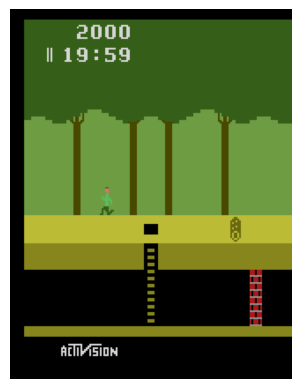

In [42]:
# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print(f"Action space: {env.action_space}")

# Sample random action
action =env.action_space.sample()
print("Action: {}".format(action))
next_state, reward, done, _,info = env.step(action)

# Print output
print("Reward: {}".format(reward))
print(f"State info :{info}")

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [43]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        #print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        # Pauze animation
        sleep(time_lag)

In [44]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

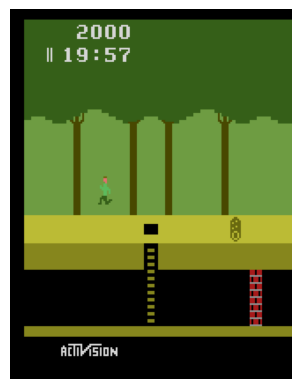

Episode: 1/1
Epoch: 49/49
Action: 12
Reward: [0.]
# epochs: 50
# failed drop-offs: 0


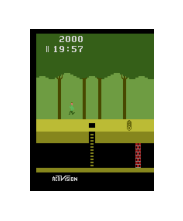

In [45]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state = env_PPO.reset()

#while not done: ## full run - takes a long time
while epoch < 50:
    # Sample random action
    "Action selection without action mask"
    action = env_PPO.action_space.sample()

    "Action selection with action mask"
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _ = env_PPO.step([action])
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env_PPO.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)
store_episode_as_gif(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))


# **2. Trying existing models**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## **Proximal Policy Optimization (PPO)**

In [3]:
"""Adapt env to return gray pictures and stack 4 frames"""
env_PPO = GrayScaleObservation(env,keep_dim=True)
env_PPO = DummyVecEnv([lambda: env_PPO])
env_PPO = VecFrameStack(env_PPO, 4, channels_order='last')

D:\Programas\anaconda\envs\py310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [6]:
"""Create model"""
model = PPO('CnnPolicy', env_PPO, verbose=1, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [7]:
"""Train Model"""
model.learn(total_timesteps=1000000)

D:\Programas\anaconda\envs\py310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


----------------------------
| time/              |     |
|    fps             | 30  |
|    iterations      | 1   |
|    time_elapsed    | 17  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.3660832e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.89         |
|    explained_variance   | -0.379        |
|    learning_rate        | 1e-06         |
|    loss                 | -0.00204      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000769     |
|    value_loss           | 0.000716      |
-------------------------------------------
-----

In [9]:
"""Save Model"""
model.save('model_1M')

In [46]:
"""Load Model"""
model = model.load('model_1M.zip')

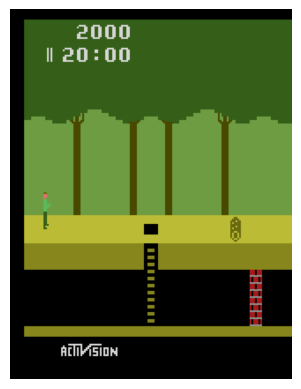

In [48]:
"""Test Model"""
import time
# Start the game 
state = env_PPO.reset()
# Loop through the game
while not done: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env_PPO.step(action)
    frame = env_PPO.render()
    clear_output()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    time.sleep(0.01)
    